In [1]:
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from math import sqrt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.linear_model import Lasso, Ridge

racs= pickle.load(open("racs.p", "rb"))
oh_values = pickle.load(open("oh_binding_energies.p", "rb"))
import matplotlib.pyplot as plt
%matplotlib inline

Optimal number of features : 36


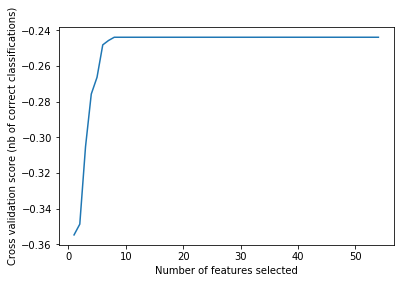

In [2]:

lr = Lasso()

rfecv = RFECV(estimator=lr, step=1, cv=100, scoring='neg_mean_absolute_error')
rfecv.fit(racs, oh_values)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features : 37


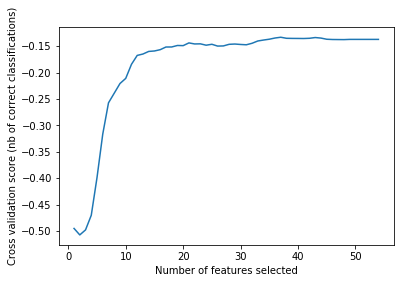

[ 1  1  1  3 11  4  7 13 14  1  8  1  1  1 10  1  1  1  1  1  1  1  9  2
  1  1  1  1  1  5 15 16 18  1  1  1  1 12  1  1  1  1  1  1  1  1 17  1
  6  1  1  1  1  1]


In [21]:

rr = Ridge()

rfecv = RFECV(estimator=rr, step=1, cv=100, scoring='neg_median_absolute_error')
rfecv.fit(racs, oh_values)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print(rfecv.ranking_)

In [22]:
explained_indices = pickle.load(open("indices_of_3_3_racs.p", "rb"))

remaining = [x for x, y in zip(explained_indices, rfecv.support_) if y]
indices = [idx for idx, y in enumerate(rfecv.support_) if y]
#explained_indices[rfecv.support_]

In [23]:
print(remaining)

['MC-mult-electronegativity-0', 'MC-mult-electronegativity-1', 'MC-mult-electronegativity-2', 'MC-mult-nuclear_charge-2', 'MC-diff-nuclear_charge-1', 'MC-diff-nuclear_charge-2', 'MC-diff-nuclear_charge-3', 'MC-mult-ident-1', 'MC-mult-ident-2', 'MC-mult-ident-3', 'MC-diff-ident-1', 'MC-diff-ident-2', 'MC-diff-ident-3', 'MC-mult-topology-0', 'MC-mult-topology-3', 'MC-diff-topology-1', 'MC-diff-topology-2', 'MC-diff-topology-3', 'MC-mult-size-0', 'MC-diff-size-2', 'MC-diff-size-3', 'MC-mult-effective_nuclear_charge-0', 'MC-mult-effective_nuclear_charge-1', 'MC-mult-effective_nuclear_charge-3', 'MC-diff-effective_nuclear_charge-1', 'MC-diff-effective_nuclear_charge-2', 'MC-diff-effective_nuclear_charge-3', 'LC-mult-electronegativity-0', 'LC-mult-electronegativity-1', 'LC-mult-electronegativity-2', 'LC-mult-nuclear_charge-0', 'LC-mult-nuclear_charge-2', 'LC-mult-ident-1', 'LC-mult-ident-2', 'LC-mult-topology-0', 'LC-mult-topology-1', 'LC-mult-topology-2']


In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import LeaveOneOut

racs = list(racs)
reduced_racs = []
for r in racs:
    reduced_racs.append([r[idx] for idx in indices])

cat_names_for_ml = pickle.load(open("cat_names_for_ml.p", "rb"))
reduced_racs = np.asarray(reduced_racs)

stdzz = []
preds = []
test_ohs = []
errs = []

loo = LeaveOneOut()
loo.get_n_splits(racs)

for train_index, test_index in loo.split(reduced_racs, oh_values):
    sc = StandardScaler()
    X_train, X_test = reduced_racs[train_index], reduced_racs[test_index]
    y_train, y_test = np.asarray(oh_values)[train_index], np.asarray(oh_values)[test_index]
    scaled_X_train = sc.fit_transform(X_train)
    scaled_X_test = sc.transform(X_test)
    #kernel =  ConstantKernel(constant_value_bounds=(1e-2, 1e2))*RBF(.1, length_scale_bounds=(1e-3, 1e3))
    
    kernel = ConstantKernel(.1, (1e-2, 1e3)) * RBF(1, (1e-3, 1e3))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=.033, n_restarts_optimizer=20)
    #gp = GaussianProcessRegressor()
    gp.fit(scaled_X_train, y_train)
    
    pred, std = gp.predict(scaled_X_test, return_std=True)
    stdzz.append(std[0])
    preds.append(pred[0])
    errs.append(abs(y_test[0]-pred[0]))
    test_ohs.append(y_test[0])
    print(np.asarray(cat_names_for_ml)[test_index][0])
    print("Uncertainty is: {:.3f}".format(std[0]))
    print("Prediction is: {:.3f}".format(pred[0]))
    print("True value is: {:.3f}".format(y_test[0]))
    print("Err is: {:.3f}".format(y_test[0]-pred[0]))

Ni_oct_desorbed_5_
Uncertainty is: 0.105
Prediction is: 2.205
True value is: 2.215
Err is: 0.010
Ru_oct_desorbed_5_
Uncertainty is: 0.083
Prediction is: 1.217
True value is: 1.213
Err is: -0.004
Cr_oct_desorbed_6_
Uncertainty is: 0.097
Prediction is: 0.149
True value is: 0.067
Err is: -0.082
Ru_3a1_4_
Uncertainty is: 0.071
Prediction is: 0.898
True value is: 0.950
Err is: 0.052
Co_oct_desorbed_2_
Uncertainty is: 0.071
Prediction is: 1.843
True value is: 1.915
Err is: 0.072
Ni_32a_31
Uncertainty is: 0.107
Prediction is: 1.859
True value is: 1.906
Err is: 0.048
Ni_32a_35
Uncertainty is: 0.112
Prediction is: 1.803
True value is: 1.863
Err is: 0.060
Ni_32a_34
Uncertainty is: 0.089
Prediction is: 1.872
True value is: 1.916
Err is: 0.044
Mn_3a1_28
Uncertainty is: 0.076
Prediction is: 1.396
True value is: 1.355
Err is: -0.041
Ru_3a1_8_
Uncertainty is: 0.126
Prediction is: 0.652
True value is: 0.603
Err is: -0.049
Ru_oct_desorbed_6_
Uncertainty is: 0.083
Prediction is: 1.204
True value is: 1.2

Ru_3a1_25
Uncertainty is: 0.100
Prediction is: 0.829
True value is: 0.803
Err is: -0.026
Mn_31a_5_
Uncertainty is: 0.142
Prediction is: 1.242
True value is: 1.356
Err is: 0.114
Ru_3a1_27
Uncertainty is: 0.056
Prediction is: 0.750
True value is: 0.704
Err is: -0.046
Mn_pbp_4_
Uncertainty is: 0.100
Prediction is: 1.513
True value is: 1.569
Err is: 0.055
Ru_3a1_20
Uncertainty is: 0.051
Prediction is: 0.878
True value is: 0.883
Err is: 0.005
Ru_3a1_23
Uncertainty is: 0.055
Prediction is: 0.807
True value is: 0.740
Err is: -0.067
Ru_3a1_22
Uncertainty is: 0.054
Prediction is: 0.801
True value is: 0.804
Err is: 0.004
Cr_31a_19
Uncertainty is: 0.091
Prediction is: 0.078
True value is: 0.168
Err is: 0.091
Ru_31a_18
Uncertainty is: 0.061
Prediction is: 0.570
True value is: 0.545
Err is: -0.025
Co_3a1_3_
Uncertainty is: 0.055
Prediction is: 1.282
True value is: 0.990
Err is: -0.291
Cr_31a_17
Uncertainty is: 0.105
Prediction is: -0.047
True value is: 0.097
Err is: 0.143
Ru_31a_19
Uncertainty is: 

/home/michael/anaconda3/envs/molSimplify/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 6.68187921e-06, -1.79923808e-05]), 'nit': 10, 'funcalls': 52}
  ConvergenceWarning)


Cr_oct_desorbed_5_
Uncertainty is: 0.097
Prediction is: 0.143
True value is: 0.088
Err is: -0.054
Cr_3a1_3_
Uncertainty is: 0.100
Prediction is: 0.169
True value is: 0.239
Err is: 0.070
Mn_oct_desorbed_3_
Uncertainty is: 0.085
Prediction is: 1.533
True value is: 1.551
Err is: 0.018
Mn_32a_34
Uncertainty is: 0.110
Prediction is: 1.372
True value is: 1.479
Err is: 0.106
Co_31a_30
Uncertainty is: 0.051
Prediction is: 1.460
True value is: 1.710
Err is: 0.251
Mn_41a_3_
Uncertainty is: 0.273
Prediction is: 1.063
True value is: 0.974
Err is: -0.088
Mn_pbp_1_
Uncertainty is: 0.121
Prediction is: 1.570
True value is: 1.583
Err is: 0.013
Ru_31a_14
Uncertainty is: 0.051
Prediction is: 0.666
True value is: 0.603
Err is: -0.063
Ru_31a_15
Uncertainty is: 0.051
Prediction is: 0.666
True value is: 0.602
Err is: -0.064
Co_3a1_19
Uncertainty is: 0.061
Prediction is: 1.440
True value is: 1.502
Err is: 0.062
Ru_31a_17
Uncertainty is: 0.061
Prediction is: 0.570
True value is: 0.542
Err is: -0.028
Ru_31a_10

0.133879032479


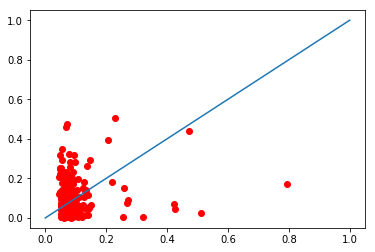

In [25]:
print(sqrt(mean_squared_error(np.asarray(test_ohs), np.asarray(preds))))
plt.plot(stdzz, errs, 'ro')
plt.plot([0,1],[0,1])

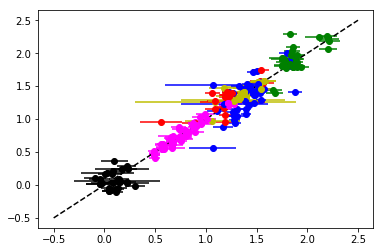

In [26]:
ele2col = {
    "Fe": "r",
    "Mn": "y",
    "Co": "b",
    "Cr": "k",
    "Ru": "fuchsia",
    "Ni": "g"
}
plt.plot([-0.5, 2.5], [-0.5, 2.5], 'k--')
for name, p, val, std in zip(cat_names_for_ml, preds, test_ohs, stdzz):
    plt.errorbar(p, val, xerr=std, fmt='o', color=ele2col[name[:2]])

0.09422281500906335


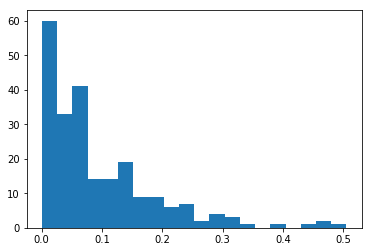

In [27]:
plt.hist(errs, bins=20)
print(np.mean(abs(np.asarray(preds)-np.asarray(test_ohs))))

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha": np.logspace(-5, 5, 15)}
estimator = GridSearchCV(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20), cv=33, param_grid=param_grid, scoring='neg_mean_absolute_error')

estimator.fit(scaled_X_train, y_train)

/home/michael/anaconda3/envs/molSimplify/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ 0.0022977 , -0.00169394]), 'nit': 6, 'funcalls': 57}
  ConvergenceWarning)
/home/michael/anaconda3/envs/molSimplify/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([4.86713275e-03, 2.33567813e-17]), 'nit': 6, 'funcalls': 49}
  ConvergenceWarning)
/home/michael/anaconda3/envs/molSimplify/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-3.09611857e-03,  2.45189727e-15]), 'nit': 6, 'funcalls': 48}
  ConvergenceWarning)
/h

/home/michael/anaconda3/envs/molSimplify/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([7.03741331e-04, 5.28820078e-16]), 'nit': 6, 'funcalls': 54}
  ConvergenceWarning)
/home/michael/anaconda3/envs/molSimplify/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-0.00073093,  0.00090646]), 'nit': 11, 'funcalls': 66}
  ConvergenceWarning)
/home/michael/anaconda3/envs/molSimplify/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([5.20650996e-04, 1.65857512e-18]), 'nit': 5, 'funcalls': 48}
  ConvergenceWarning)
/ho

KeyboardInterrupt: 

In [ ]:
estimator.best_estimator_